In [ ]:
# AE : 각 이미지가 잠재공간의 한 포인트에 대해 직접 매핑됩니다.
# VAE(변이형 오토인코더) : 각 이미지가 잠재 공간에 있는 포이니트 주변의 다변량 정규 분포에 매핑

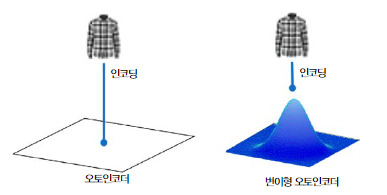

In [ ]:
# 다변량 정규 분포
# 정규분포(가우스분포) : 평균,분산을 가지고 종 모양의 곡선을 가지는 확률분포

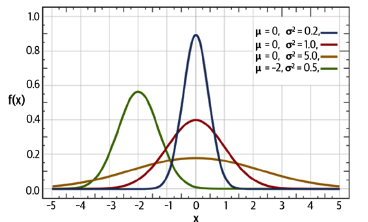

In [ ]:
# 평균과 분산이 각각 다른 1차원 정규분포 여러개...
# 빨간곡선은 평균이 0, 분산이 1
# 평균이 U이고 표준편차가 시그마인 정규분포에서 포인트 z를 샘플링
# z = U + 시그마*e    e: 표준 정규분포에서 샘플링
# 다변량 정규 분포 : N(0,1) 평균벡터가 0이고 공분산 행렬이 단위벡터인

변이형 오토 인코더의 구조


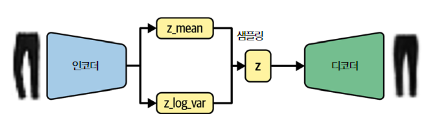

In [ ]:
# z_mean : 해당 분포의 평균벡터
# z_log_var : 차원별 분산의 로그 값

In [ ]:
# 참조 사이트 : 케라스 참조   https://keras.io/examples/generative/vae/

In [ ]:
!pip install scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from scipy.stats import norm

In [ ]:
# 파라메터
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS=5
BETA = 500

In [ ]:
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# 데이터 전처리
def preprocess(imgs):
  imgs = imgs.astype('float32') / 255.0
  imgs = np.pad(imgs,((0,0),(2,2),(2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):  # 상속
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # 정규분포에서 셈플링

In [14]:
# 인코더
latent_dim = 2

encoder_inputs = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
# flatten층을 잠재공간에 바로 연결안하고 z_mean, z_log_var층에 연결
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # 샘플링
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 16, 16, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_5[0][0]']            
                                                                                            

In [ ]:
# 디코더
decorder_input = layers.Input(shape=(EMBEDDING_DIM,))
x = layers.Dense(np.prod(shape_before_flatten))(decorder_input) # 2048
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(128,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(x)
decoder_output = layers.Conv2D(1,(3,3),strides=1,activation='sigmoid',padding='same')(x) # 이미지 그려야..
decorder = models.Model(decorder_input,decoder_output)
decorder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [15]:
#훈련 VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self,inputs): # 특정 입력 이미지에서 VAE를 호출했을때 반환값
      z_mean,z_log_var,z = encoder(inputs)
      reconstruction = decorder(z)
      return z_mean,z_log_var,reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [16]:
# 변이형 오토 인코더 생성
vae = VAE(encoder,decorder)

In [17]:
optimizer = optimizers.Adam(learning_rate = 0.0005)
vae.compile(optimizer=optimizer)

In [20]:
# 모델 저장 콜백함수
model_check_point = callbacks.ModelCheckpoint(
    filepath = './checkpoint',
    save_weights_only = False,
    save_freq = 'epoch',
    monitor = 'loss',
    mode = 'min',
    save_best_only = True,
    verbose =0
)
tensorboard_callback =  callbacks.TensorBoard(log_dir = './logs')

In [ ]:
vae.fit(
    x_train,
    epochs =EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = True,
    validation_data = (x_test,y_test),
    callbacks = [model_check_point,tensorboard_callback]
)

Epoch 1/5
588/600 [============================>.] - ETA: 0s - total_loss: 161.1571 - reconstruction_loss: 156.6506 - kl_loss: 4.5066